In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
data = pd.read_csv("credit_risk_dataset.csv")
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [4]:
print("Пропуски в данных:")
data.isna().sum()

Пропуски в данных:


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

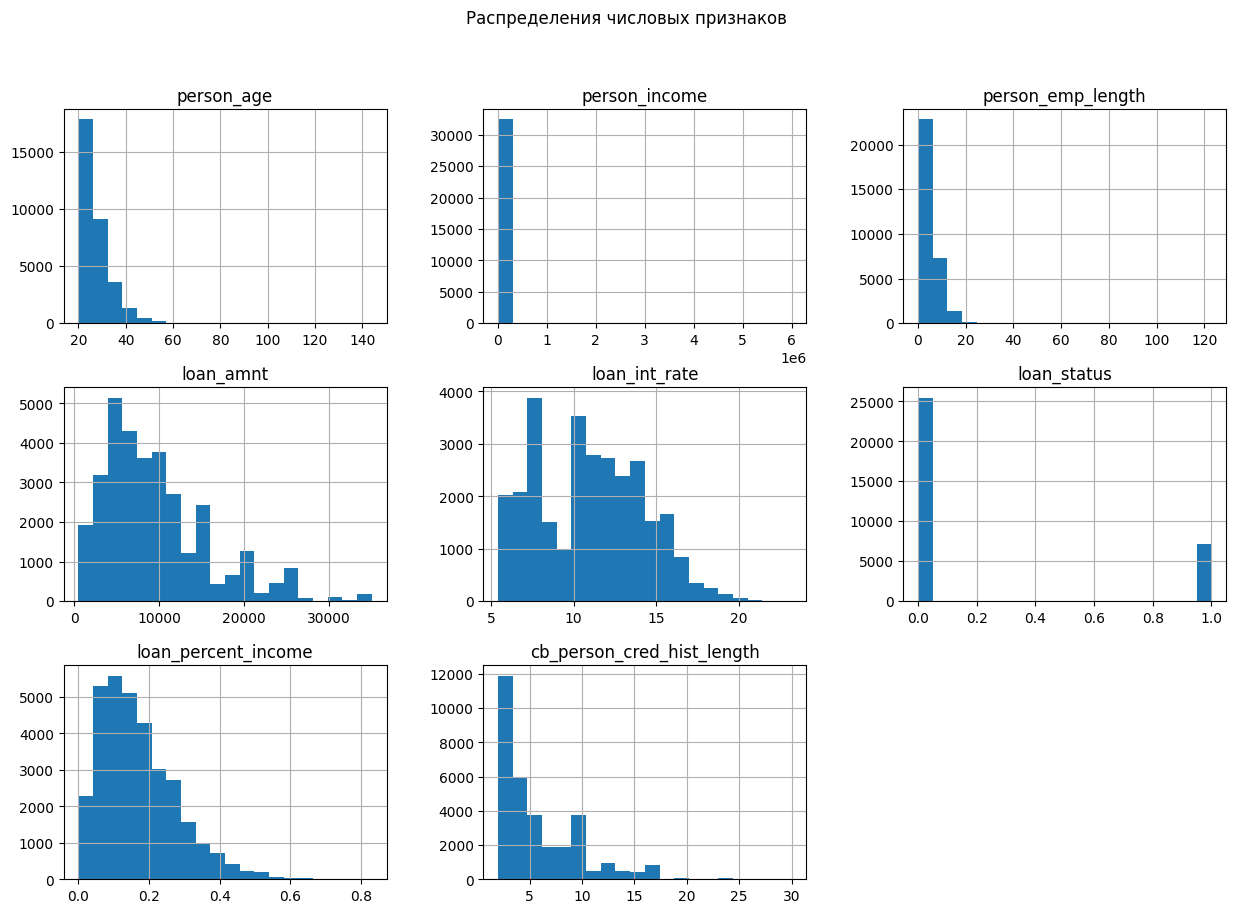

In [5]:
num_cols = data.select_dtypes(include=np.number).columns
data[num_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Распределения числовых признаков")
plt.show()

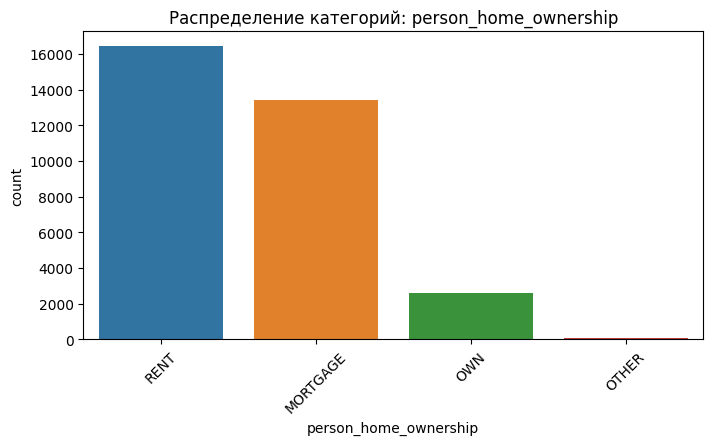

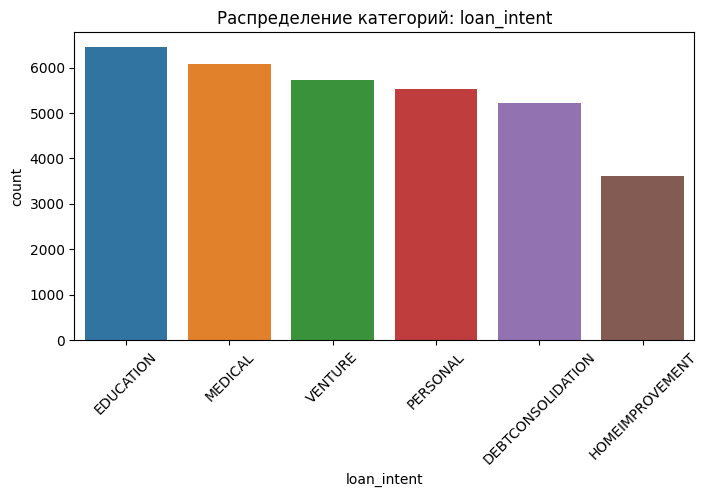

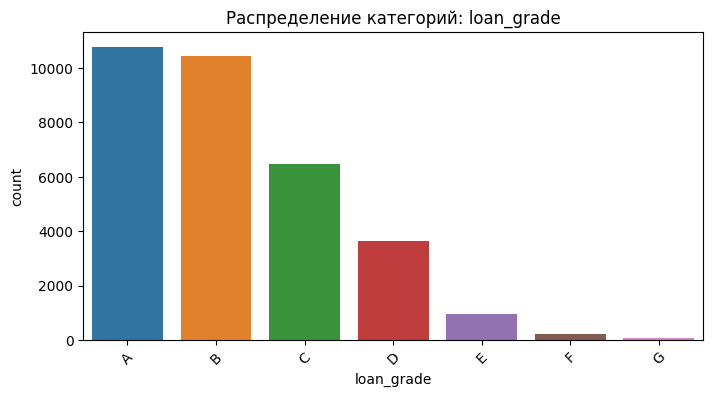

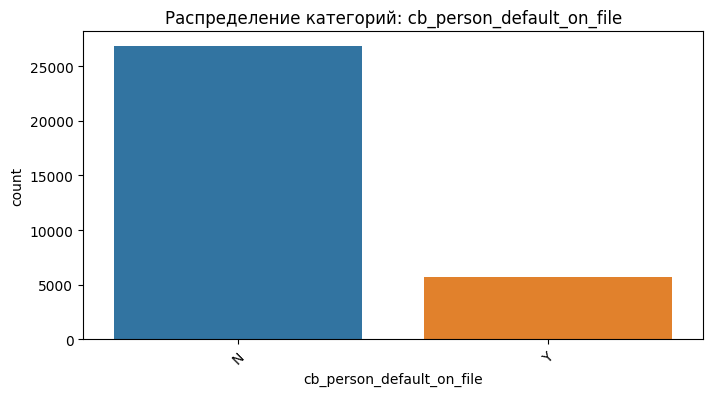

In [6]:
cat_cols = data.select_dtypes(exclude=np.number).columns
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=data, order=data[col].value_counts().index)
    plt.title(f"Распределение категорий: {col}")
    plt.xticks(rotation=45)
    plt.show()

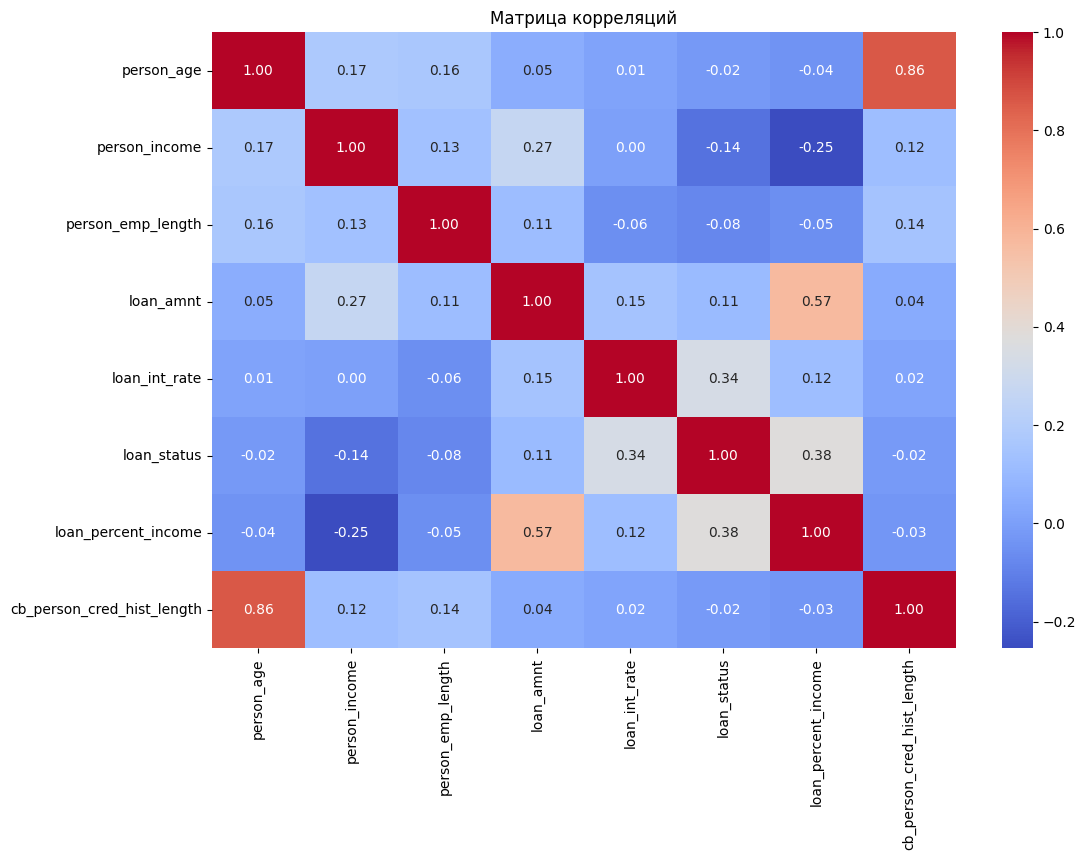

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Матрица корреляций")
plt.show()

In [8]:
# добавление новых "фичей":
# процентная ставка / доход 
data["int_rate_over_income"] = data["loan_int_rate"] / data["person_income"]
# сумма займа / доход
data['loan_to_income_ratio'] = data['loan_amnt'] / data['person_income']
# трудовой стаж / сумма займа
data['loan_to_emp_length_ratio'] =  data['person_emp_length']/ data['loan_amnt'] 

In [9]:
bins = [data["person_age"].min() - 1, 25, 35, 50, data["person_age"].max() + 1]
labels = ["<=25", "25-35", "35-50", "50+"]
data["age_group"] = pd.cut(data["person_age"], bins=bins, labels=labels, right=False)
data = data.drop("person_age", axis=1)
data.head()

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,int_rate_over_income,loan_to_income_ratio,loan_to_emp_length_ratio,age_group
0,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0.000272,0.593220,0.003514,<=25
1,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0.001160,0.104167,0.005000,<=25
2,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0.001341,0.572917,0.000182,25-35
3,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0.000233,0.534351,0.000114,<=25
4,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0.000262,0.643382,0.000229,<=25


In [10]:
bins=[0, 25000, 50000, 75000, 100000, float("inf")]
labels=["low", "low-middle", "middle", "high-middle", "high"]
data["income_group"] = pd.cut(data["person_income"], bins=bins, labels=labels)
data = data.drop("person_income", axis=1)
data.head()

,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,int_rate_over_income,loan_to_income_ratio,loan_to_emp_length_ratio,age_group,income_group
0,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0.000272,0.593220,0.003514,<=25,middle
1,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0.001160,0.104167,0.005000,<=25,low
2,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0.001341,0.572917,0.000182,25-35,low
3,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0.000233,0.534351,0.000114,<=25,middle
4,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0.000262,0.643382,0.000229,<=25,middle


In [11]:
bins=[0, 5000, 10000, 15000, float('inf')]
labels = ["small", "medium", "large", "very large"]
data["loan_amount_group"] = pd.cut(data["loan_amnt"], bins=bins, labels=labels)
data.drop("loan_amnt", axis=1)
data.head()

,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,int_rate_over_income,loan_to_income_ratio,loan_to_emp_length_ratio,age_group,income_group,loan_amount_group
0,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0.000272,0.593220,0.003514,<=25,middle,very large
1,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0.001160,0.104167,0.005000,<=25,low,small
2,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0.001341,0.572917,0.000182,25-35,low,medium
3,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0.000233,0.534351,0.000114,<=25,middle,very large
4,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0.000262,0.643382,0.000229,<=25,middle,very large


In [12]:
X = data.drop(["loan_status"], axis=1)
y = data["loan_status"]
print("Пропуски в данных после преобразований:")
X.isna().sum()

Пропуски в данных после преобразований:


person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
int_rate_over_income          3116
loan_to_income_ratio             0
loan_to_emp_length_ratio       895
age_group                        0
income_group                     0
loan_amount_group                0
dtype: int64

In [13]:
# заполнение медианой пропусков в колонках с числовыми признаками
X = X.fillna(X.median(numeric_only=True))

In [16]:
# заполнение модой пропусков в колонках с категориальными признаками 
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# проверка на наличие пропусков после их заполнения 
X.isna().sum()

person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
int_rate_over_income          0
loan_to_income_ratio          0
loan_to_emp_length_ratio      0
age_group                     0
income_group                  0
loan_amount_group             0
dtype: int64

In [21]:
# кодирование категорильных признаков при помощи OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(X[cat_cols])
feature_names = encoder.get_feature_names_out(cat_cols)
encoded_df = pd.DataFrame(encoded_array, columns=feature_names)
X_encod = pd.concat([X.drop((cat_cols), axis=1), encoded_df], axis=1)
X_encod.shape

(32581, 40)

In [43]:
# разбиение данных на тестовую и тренировочную выборки 
X_train, X_test, y_train, y_test = train_test_split(X_encod, y, test_size=0.3, stratify=y, random_state=42)

In [44]:
# нормализация данных при помощи StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# словарь моделей
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

In [46]:
# обучение и сбор метрик
metrics = {name: {} for name in models}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    metrics[name]["accuracy"] = accuracy_score(y_test, y_pred)
    metrics[name]["precision"] = precision_score(y_test, y_pred, zero_division=0)
    metrics[name]["recall"] = recall_score(y_test, y_pred, zero_division=0)
    metrics[name]["f1"] = f1_score(y_test, y_pred, zero_division=0)

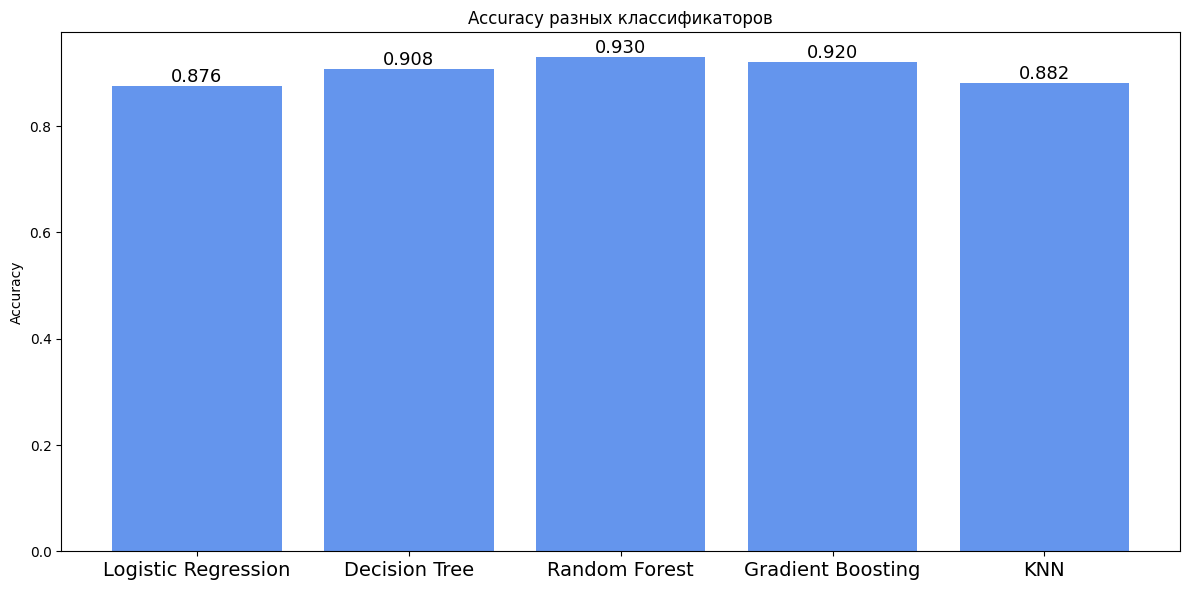

In [47]:
# визуализация точности всех моделей 
names = list(metrics.keys())
acc = [metrics[n]["accuracy"] for n in names]

plt.figure(figsize=(12, 6))
bars = plt.bar(names, acc, color="cornflowerblue")
plt.ylabel("Accuracy")
plt.title("Accuracy разных классификаторов")
plt.xticks(fontsize=14)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{h:.3f}", ha="center", va="bottom", fontsize=13)
plt.tight_layout()
plt.show()

In [48]:
print("Метрики по моделям:")
for name in names:
    m = metrics[name]
    print(f"{name:20} | Acc: {m['accuracy']:2.3f} | Prec: {m['precision']:2.3f} | Rec: {m['recall']:2.3f} | F1: {m['f1']:2.3f}")

Метрики по моделям:
Logistic Regression  | Acc: 0.876 | Prec: 0.778 | Rec: 0.602 | F1: 0.679
Decision Tree        | Acc: 0.908 | Prec: 0.950 | Rec: 0.612 | F1: 0.745
Random Forest        | Acc: 0.930 | Prec: 0.956 | Rec: 0.713 | F1: 0.817
Gradient Boosting    | Acc: 0.920 | Prec: 0.930 | Rec: 0.686 | F1: 0.790
KNN                  | Acc: 0.882 | Prec: 0.786 | Rec: 0.629 | F1: 0.698


In [49]:
# ансамблирование моделей (LogisticRegression, RandomForestClassifier, KNeighborsClassifier,
# CatBoostClassifier) при помощи VotingClassifier

lr =  LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
cat = CatBoostClassifier(iterations=500, random_seed=42, learning_rate=.02, verbose=0)

voting = VotingClassifier(estimators=[
    ("lr", lr),
    ("rf", rf),
    ("cat", cat),
    ("knn", knn)
], voting='soft')
voting.fit(X_train, y_train)
y_pred_vote = voting.predict(X_test)
print("Ensemble: Soft Voting")
print("Accuracy:", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_vote, zero_division=0))
print("F1:", f1_score(y_test, y_pred_vote, zero_division=0))

Ensemble: Soft Voting
Accuracy: 0.9214322250639386
Precision: 0.9394719896973599
Recall: 0.6840131270511017
F1: 0.7916440586001084
